## Install packages

In [1]:
# install.packages("StMoMo")
# install.packages("forecast")
# install.packages("demography")

In [34]:
library("demography")
library("forecast")


In [35]:
#United Kingdom
# -- UK Total Population	GBR_NP
# -- England & Wales Total Population	GBRTENW
# -- England & Wales Civilian Population	GBRCENW
# -- Scotland	GBR_SCO
# -- Northern Ireland	GBR_NIR
angleterre<-hmd.mx(country="GBR_NP", username="medaminehamza12@gmail.com",password="1588003302", label="U.k")
#load(file="mortalityDatasets.RData")


Warning message in hmd.mx(country = "GBR_NP", username = "medaminehamza12@gmail.com", :
"NAs introduced by coercion"

In [5]:
help(hmd.mx)

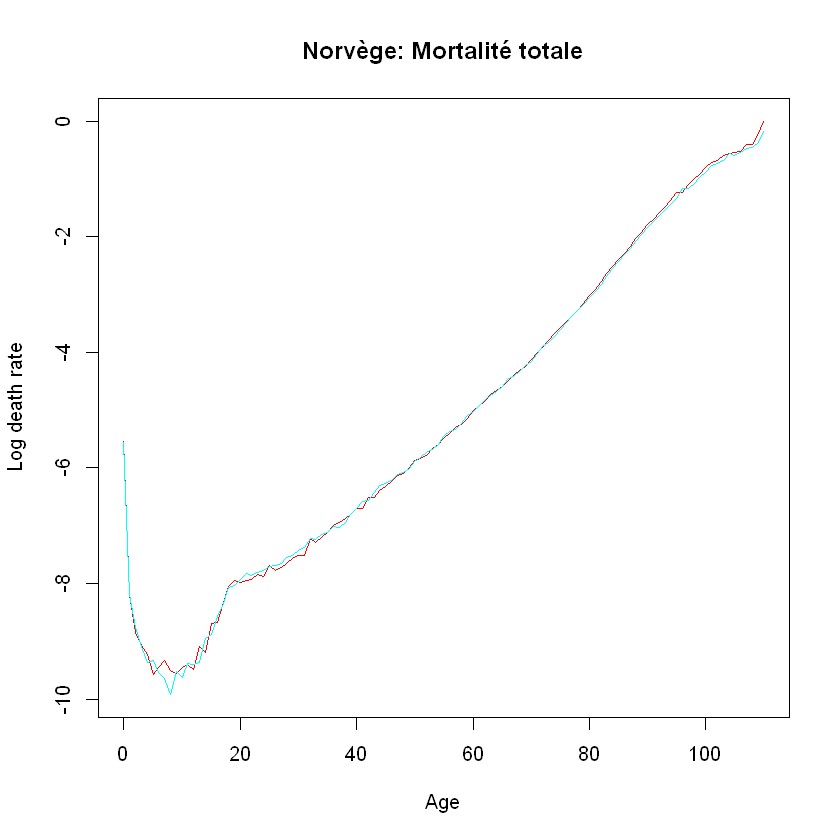

In [3]:
plot(x=angleterre,series=names(angleterre$rate)[3],
               ages=angleterre$age, years=2015:2016,
               max.age=max(angleterre$age)
               ,plot.type="functions", main="Norvège: Mortalité totale")

In [4]:
an.mort_age = extract.ages(data = angleterre, ages=angleterre$age)    
an.mort_age_yr = extract.years(data = angleterre, years = angleterre$year) 

ERROR: Error in extract.years(data = angleterre, years = years): object 'years' not found


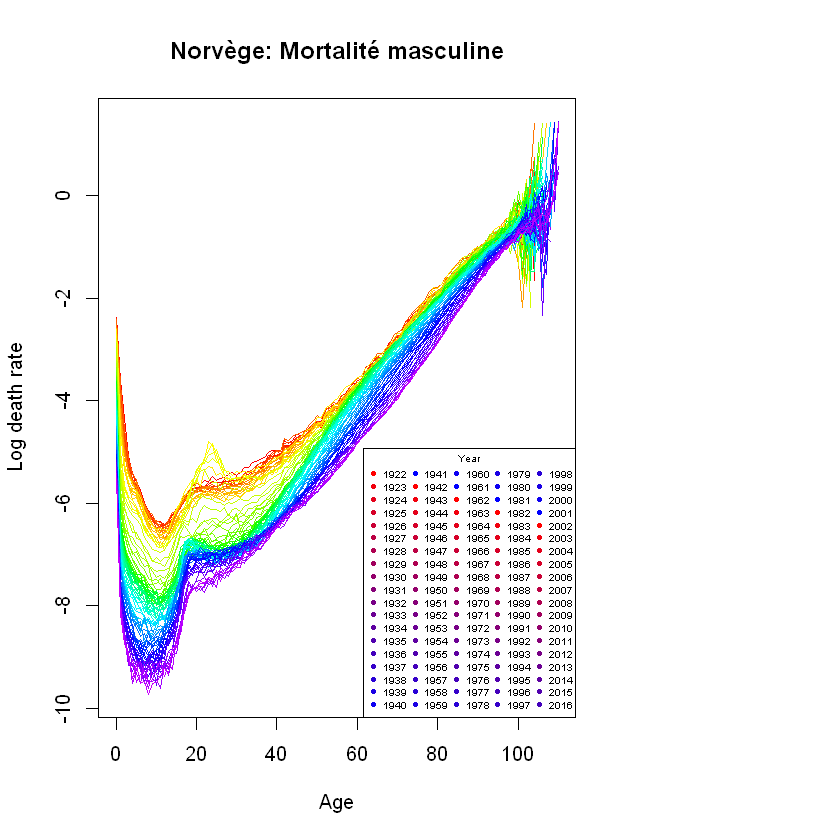

In [10]:
par(mar=c(5.1, 4.1, 4.1, 11), xpd=TRUE)
colfunc <- colorRampPalette(c("red", "blue"))
plot(x=angleterre,series=names(angleterre$rate)[2],
               ages=angleterre$age, years=angleterre$year,
               max.age=max(angleterre$age)
               ,plot.type="functions", main="Norvège: Mortalité masculine")
   
legend(legend=unique(angleterre$year),
       col=colfunc(20), ncol=5, pch=19, 
       title="Year", cex=0.5, "bottomright")

In [8]:
angleterre <- read.demogdata(file="Mx_1x1.txt", popfile="Exposures_1x1.txt",
                       type="mortality", label="United Kingdom")
names(angleterre)

[1] "type"   "label"  "lambda" "year"   "age"    "rate"   "pop"

In [3]:
summary(angleterre)

Mortality data for U.k
    Series: female male total
    Years: 1922 - 2016
    Ages:  0 - 110 


# 2/ Taux de mortalité : Etude des cohortes

En assurance vie, le principe est de suivre un individu par année de naissance pour pouvoir offir un produit d’assurance-vie pour les individus de la même génération. Ces trois dimensions $x$ (âge), $t$ (date) et $t − x$ (année de naissance) n’est pas sans rappeler la lecture des triangles de provisionnement $j$ (développement, ou âge d’un sinistre), $i+j$ (année calendaire, ou date de paiement) et $i$ (année de survenance, ou année de naissance du sinistre).

La génération est obtenue par $g = x − t$, par exemple 1980=1981-1=1982-2

Pour extraire une génération, nous avons récupéré la fonction suivante.

In [32]:
cohort <- function(year, rates, log=FALSE)
{
  xg <- diag(rates[, colnames(rates) >= year])
  names(xg) <- paste(year, rownames(rates)[1:length(xg)], sep="-x=")
  if(log)
    xg <- log(xg)
  xg
}

In [33]:
cohort_of_cohorts <- function(years, rates, log=FALSE)
{
  xgs<-vector()
  for (year in years)
  {
  xg <- diag(rates[, colnames(rates) >= year])
  names(xg) <- paste(year, rownames(rates)[1:length(xg)], sep="-x=")
  if(log)
    xg <- log(xg)
  xgs<-c(xgs,list(xg))
  }
  xgs
}

# Cohortes sur l'ensemble des années a partir de 2015

In [30]:
colfunc <- colorRampPalette(c("red", "blue"))
cohorts<-cohort(1956:2015, angleterre$rate$male,  log=T)

plot(cohort(1955, angleterre$rate$male, log=F),col=colfunc(20)[1], type="l",ylim=c(-11,-4), main="UK: Cohortes")
i<-2
for (one_cohort in cohorts){
  lines (one_cohort, col=colfunc(20)[i+56])
  i<-i+1
}
legend(legend=unique(1955:2015),
       col=colfunc(20), ncol=5, pch=19, 
       title="Year", cex=0.5, "topright")

Warning message in colnames(rates) >= year:
"longer object length is not a multiple of shorter object length"

ERROR: Error in names(xg) <- paste(year, rownames(rates)[1:length(xg)], sep = "-x="): 'names' attribute [60] must be the same length as the vector [35]


In [30]:
colfunc <- colorRampPalette(c("red", "blue"))
cohorts<-cohort_of_cohorts(demoUK$year, demoUK$rate$total,  log=T)

plot(cohort_of_cohorts(demoUK$year[1], demoUK$rate$total, log=T),col=colfunc(length(demoUK$year))[1], type="l", ylim=c(-11,5), main="Norvège: Cohortes")
i<-2
for (one_cohort in cohorts){
  lines (one_cohort, col=colfunc(length(demoUK$year))[i+93])
  i<-i+1
}
legend(legend=unique(2015:2016),
       col=colfunc(10), ncol=5, pch=19, 
       title="Year", cex=0.5, "bottomright")

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' is a list, but does not have components 'x' and 'y'


In [12]:
demoUK=angleterre

In [28]:
plot(cohort_of_cohorts(2015, demoUK$rate$total, log=T),col=colfunc(length(demoUK$year))[1], type="l", ylim=c(-11,5), main="Norvège: Cohortes")

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' is a list, but does not have components 'x' and 'y'


In [23]:
demoUK$year[93]

[1] 2014

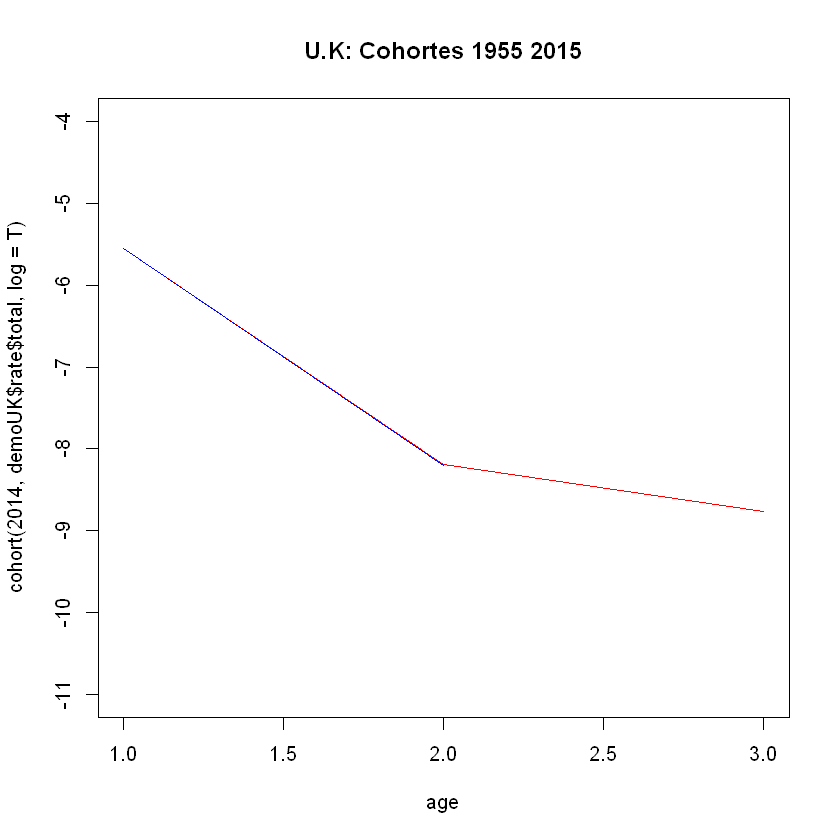

In [41]:
plot(cohort(2014, demoUK$rate$total, log=T),col="red", type="l",ylim=c(-11,-4), main="U.K: Cohortes 1955 2015",xlab="age")
lines(cohort(2015, demoUK$rate$total, log=T),col="blue")

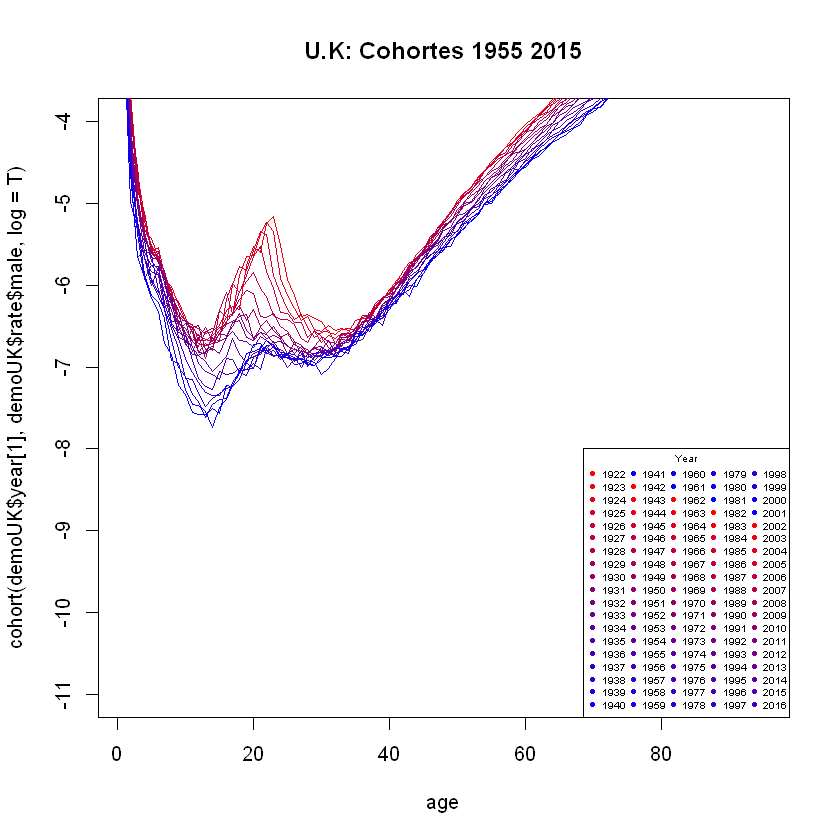

In [39]:
cohorts<-cohort_of_cohorts(demoUK$year, demoUK$rate$male,  log=T)

plot(cohort(demoUK$year[1], demoUK$rate$male, log=T),col="red", type="l",ylim=c(-11,-4), main="U.K: Cohortes 1955 2015",xlab="age")
i<-2
for (one_cohort in cohorts){
  lines (one_cohort, col=colfunc(20)[i])
  i<-i+1
}
legend(legend=unique(demoUK$year),
       col=colfunc(20), ncol=5, pch=19, 
       title="Year", cex=0.5, "bottomright")

Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"

ERROR: Error in plot.window(...): need finite 'ylim' values


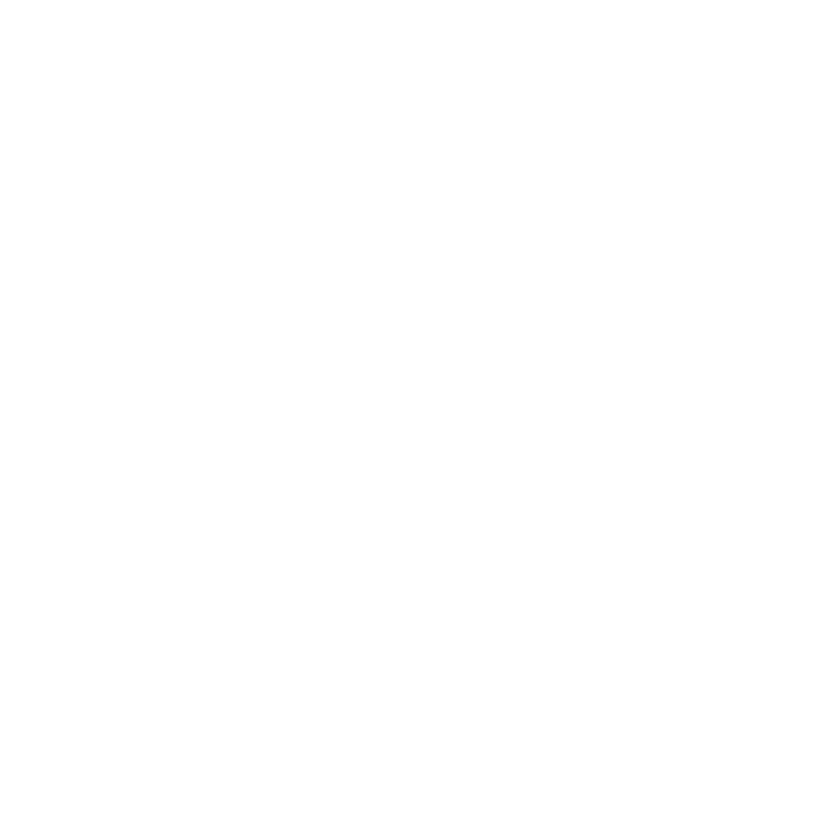

In [82]:
plot(mean(x))
plot(Max(x))
plot(Min(x))

In [75]:
library(reliaR)
#parameters
alpha <- log(1.078316)
theta <- 1.921184e-4
A <- 0.01
k <- 1.921184e-1
scale <- 1
#Gompertz
x=pgompertz(demoUK$rate$total+1, alpha=alpha, theta=theta, lower=FALSE) /
pgompertz(demoUK$rate$total, alpha=alpha, theta=theta, lower=FALSE)
#Makeham
pgompertz(demoUK$rate$total+1, alpha=alpha, theta=theta, lower=FALSE) /
pgompertz(demoUK$rate$total, alpha=alpha, theta=theta, lower=FALSE)*exp(-A)

,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,0.9898511,0.9898512,0.9898511,0.9898511,0.9898512,0.9898512,0.9898512,0.9898511,0.9898513,0.9898512,...,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522
1,0.9898519,0.9898520,0.9898519,0.9898520,0.9898520,0.9898520,0.9898520,0.9898519,0.9898521,0.9898520,...,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523
2,0.9898521,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898521,0.9898522,0.9898522,...,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523
3,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,...,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523
4,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,...,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523
5,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,0.9898522,...,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523
6,0.9898522,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,...,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523
7,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,...,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523
8,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,...,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523
9,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,...,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523,0.9898523


In [70]:
install.packages("reliaR")

Warning message:
"package 'reliaR' is in use and will not be installed"

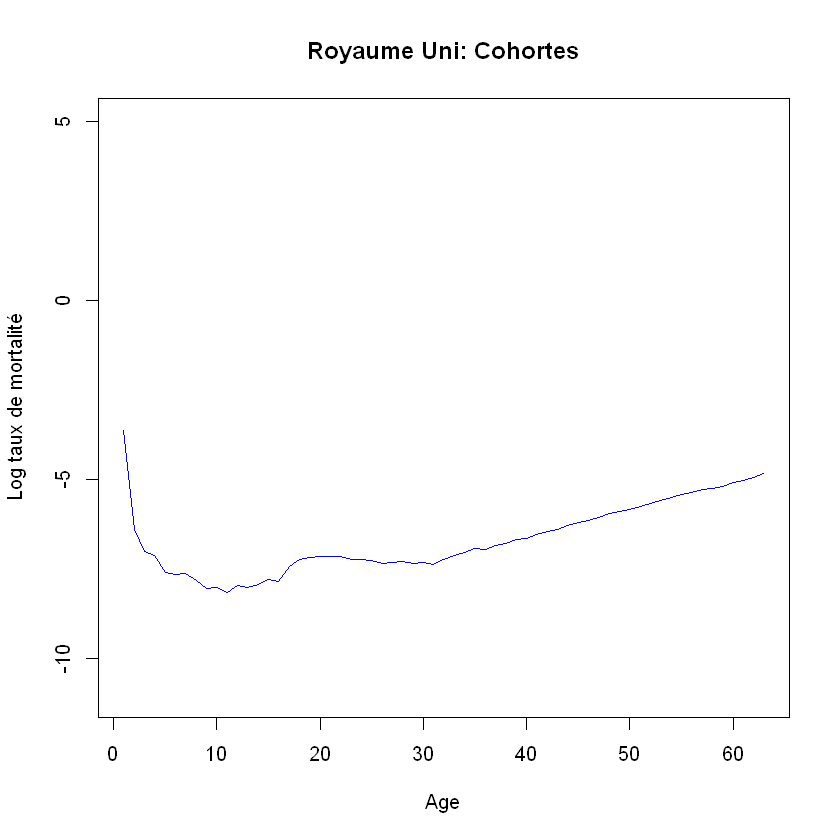

In [59]:
colfunc <- colorRampPalette(c("red", "blue"))
cohorts<-cohort_of_cohorts(demoUK$year, demoUK$rate$total,  log=T)

plot(cohort(demoUK$year[33], demoUK$rate$total, log=T),col="red", type="l", ylim=c(-11,5), main="Royaume Uni: Cohortes",xlab="Age",ylab="Log taux de mortalité")

lines(cohort(demoUK$year[33], demoUK$rate$total, log=T),col="blue", type="l", ylim=c(-11,5), main="Royaume Uni: Cohortes",xlab="Age",ylab="Log taux de mortalité")
for (one_cohort in cohorts){
  lines (one_cohort, col=colfunc(length(demoUK$year))[i+93])
 i<-i+1
}

In [56]:
demoUK$year[33]

[1] 1954

In [37]:
cohort(2015, demoUK$rate$total, log=T)

2015-x=0  2015-x=1 
-5.547292 -8.198739

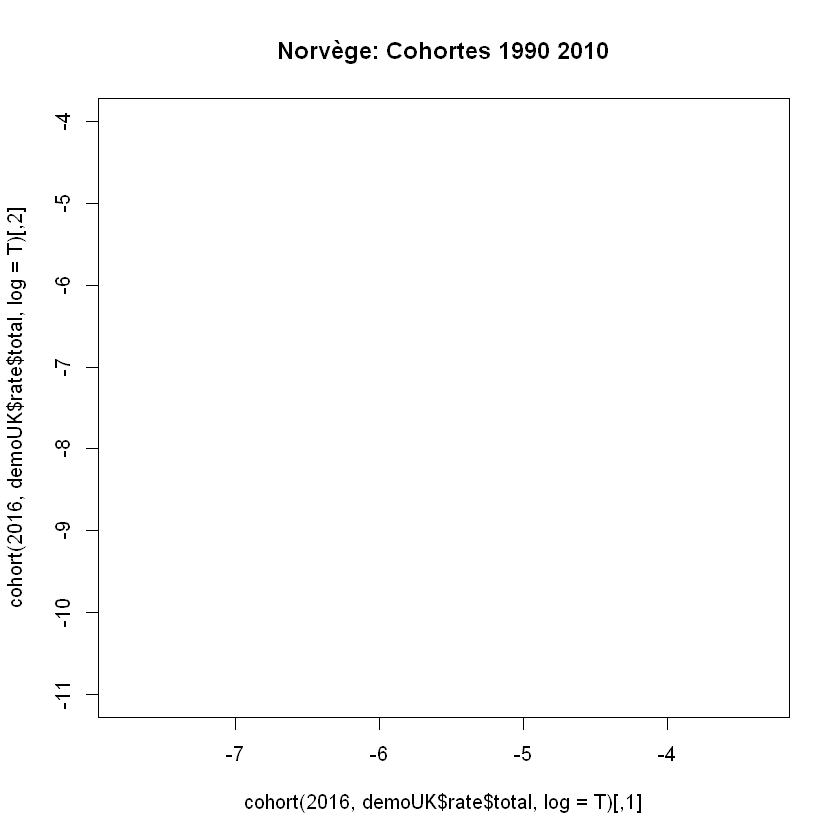

In [35]:
plot(cohort(2016, demoUK$rate$total, log=T),col=colfunc(20)[1], type="l",ylim=c(-11,-4), main="Norvège: Cohortes 1990 2010")

Warning message in colnames(rates) >= year:
"longer object length is not a multiple of shorter object length"

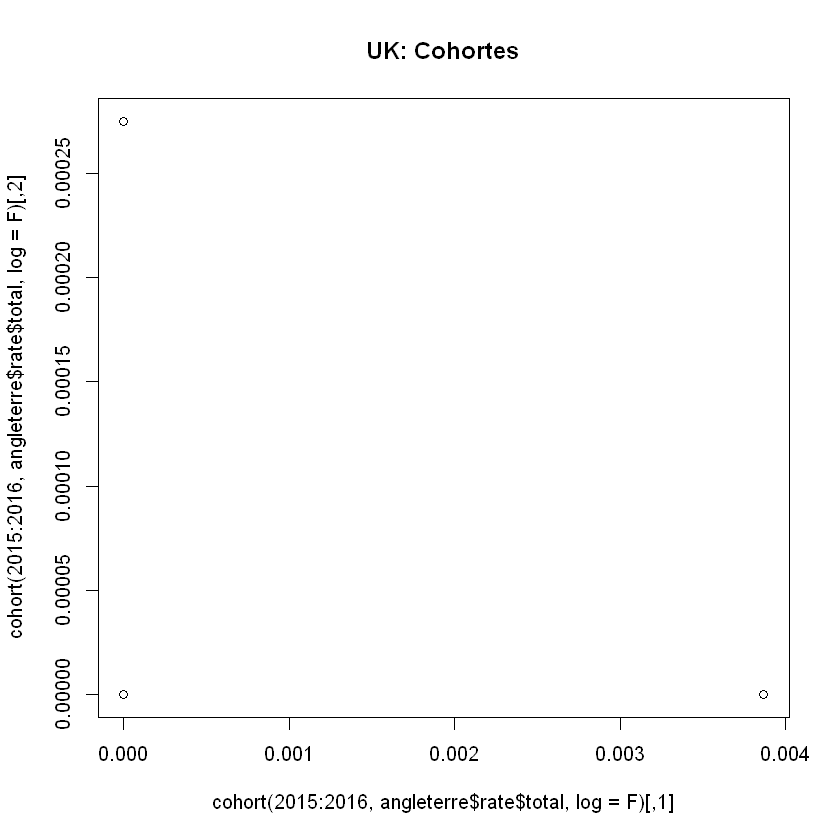

In [39]:
plot(cohort(2015:2016, angleterre$rate$total, log=F),main="UK: Cohortes")

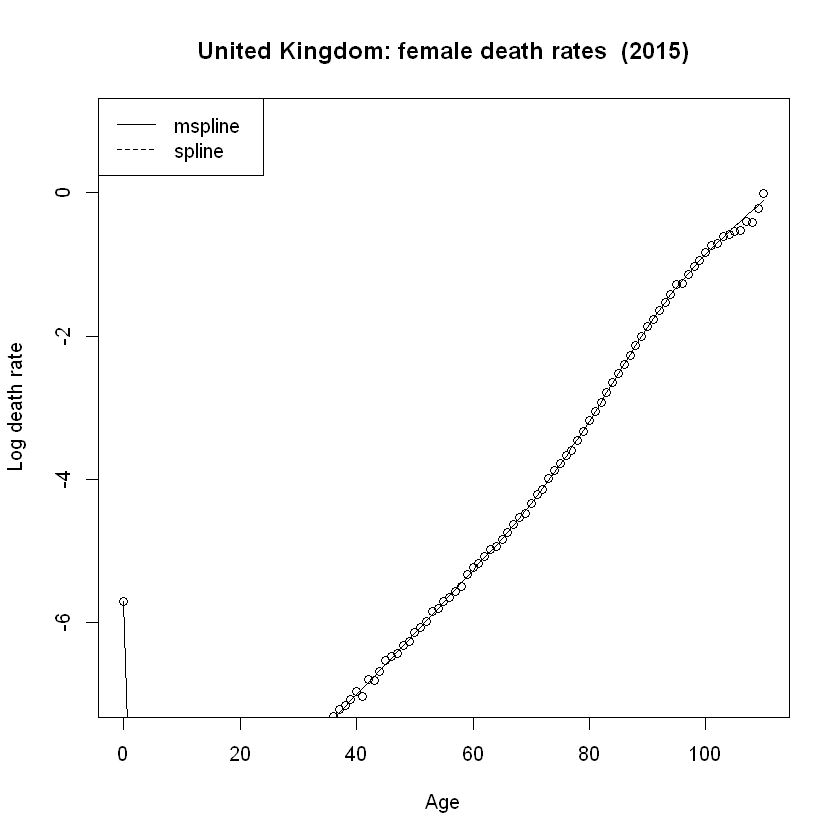

In [13]:
angleterre2015 <- extract.years(angleterre, years=2015:2016)
angleterre.smth.m <- smooth.demogdata(angleterre2015, method="mspline")
angleterre.smth.u <- smooth.demogdata(angleterre2015, method="spline")
plot(angleterre, years=2015, type="p", pch=21, ylim=c(-7, 1))
lines(angleterre.smth.m, years=2015)
lines(angleterre.smth.u, years=2015, lty=3)
legend("topleft", lty=1:3, col="black", leg=c("mspline", "spline"))


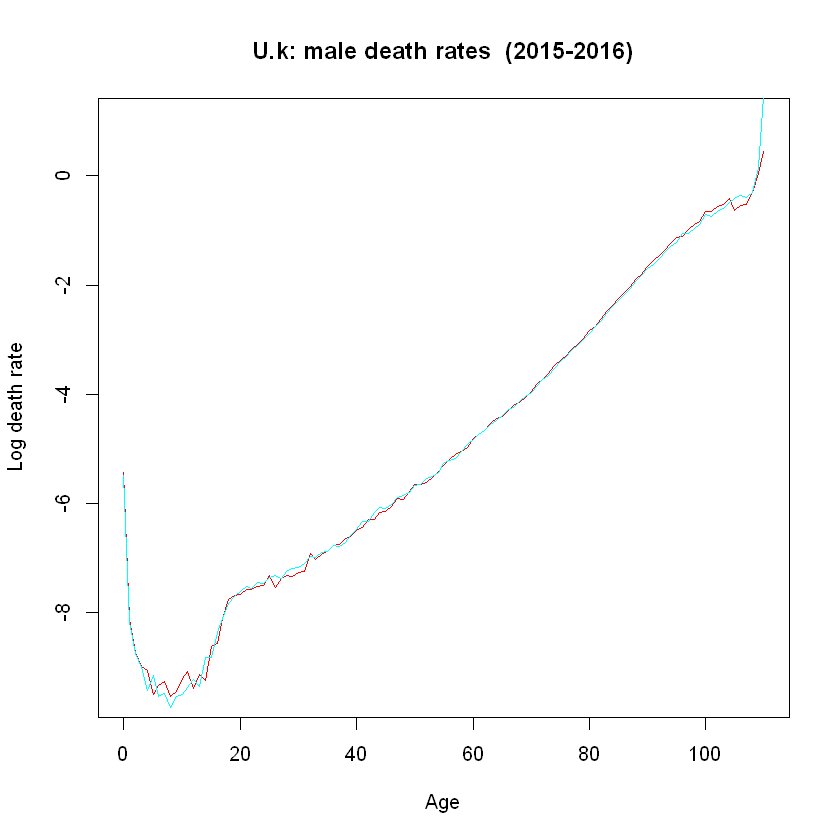

In [34]:
plot(angleterre, years=2015:2016, pch=21, ylim=c(-9.5, 1),series="male")

In [51]:
## Calcul des quantiles à 0.95 et 0.05
qsup <- apply(cohort(2016, angleterre$rate$male,log=T),MARGIN=2,FUN=quantile,probs=0.95)
qinf <- apply(cohort(2016, angleterre$rate$male,log=T),MARGIN=2,FUN=quantile,probs=0.05)


ERROR: Error in plot.window(...): need finite 'xlim' values


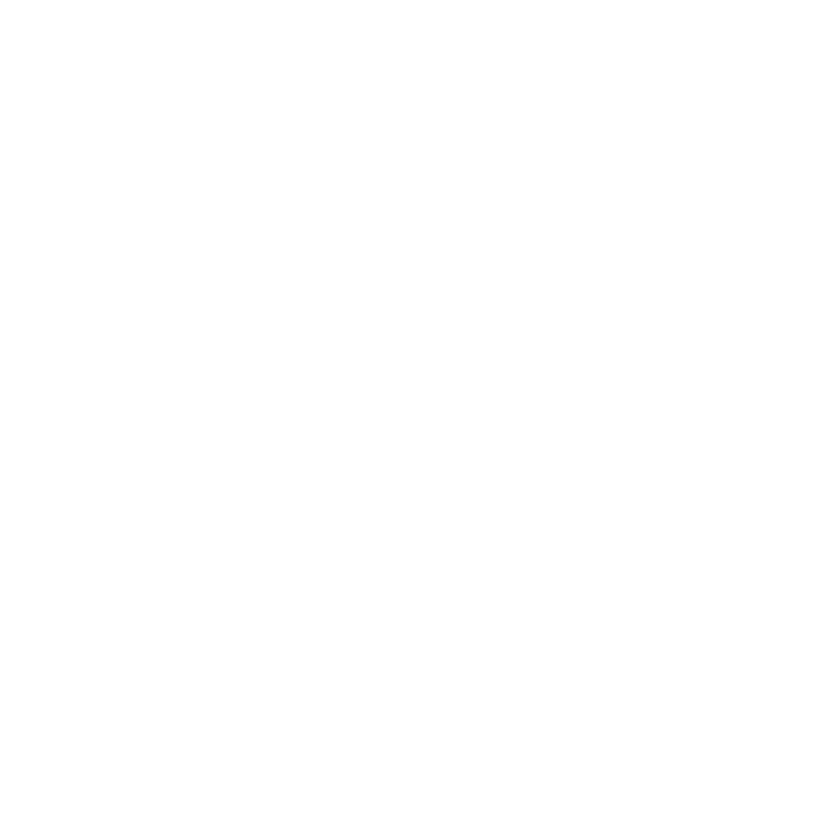

In [56]:
plot(NULL,NULL,xlim=c(min(cohort(2016, angleterre$rate$male,log=T)),max(cohort(2016, angleterre$rate$male,log=T))),ylim=c(min(qinf),max(qsup)),
   xlab="lambda",ylab="reflectance")

## Intervalle de confiance [0.025;0.975]
polygon(x=c(cohort(2016, angleterre$rate$male,log=T),rev(cohort(2016, angleterre$rate$male,log=T))),y=c(qinf,rev(qsup)),col="grey",border=NA)

## Courbe moyenne

lines(cohort(2016, angleterre$rate$male,log=T),colMeans(cohort(2016, angleterre$rate$male,log=T)),lwd=2,col="blue")

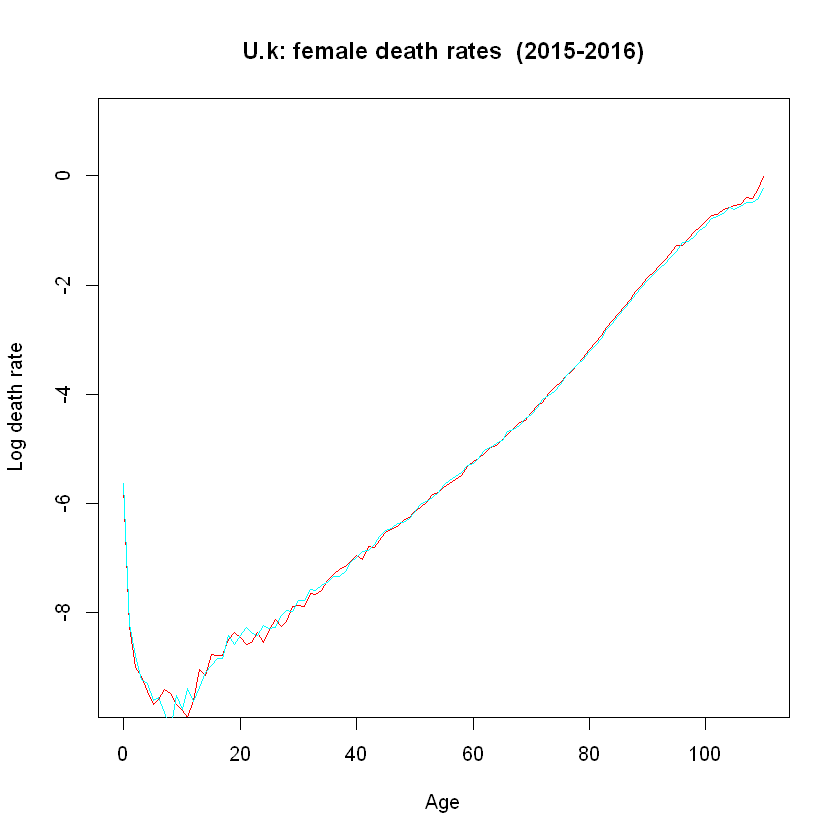

In [35]:
plot(angleterre, years=2015:2016, pch=21, ylim=c(-9.5, 1),series="female")

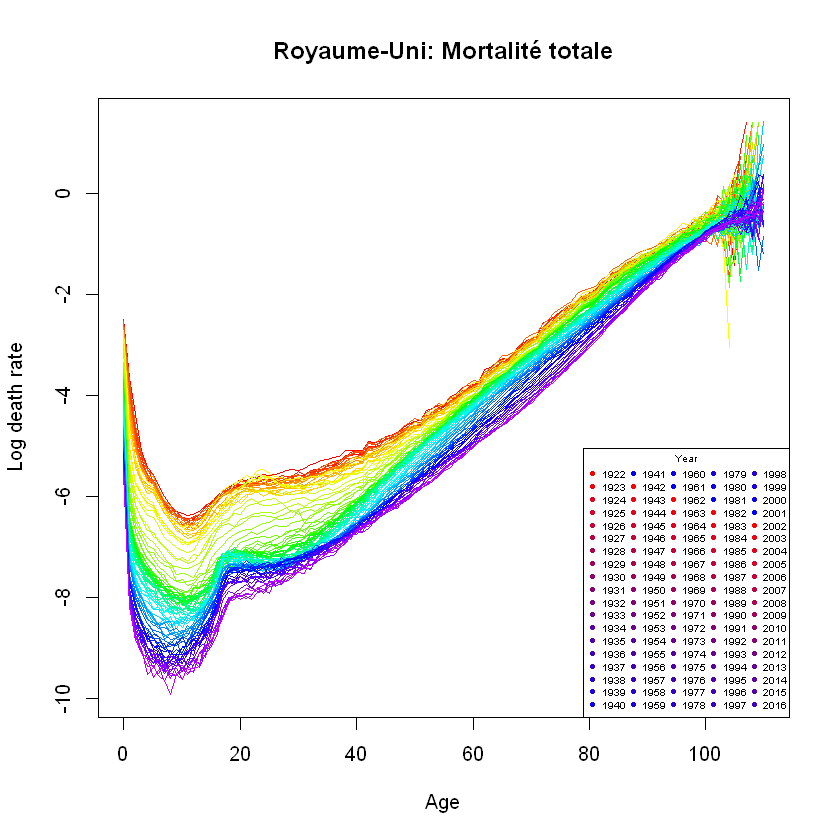

In [31]:
plot(x=angleterre,series=names(angleterre$rate)[3],
               ages=angleterre$age, years=angleterre$year,
               max.age=max(angleterre$age)
               ,plot.type="functions", main="Royaume-Uni: Mortalité totale")
legend(legend=unique(angleterre$year),
       col=colfunc(20), ncol=5, pch=19, 
       title="Year", cex=0.5, "bottomright")

# 3/ Lee carter

Le modèle Lee-Carter est une formule numérique utilisée dans la prévision de la mortalité et la prévision de l'espérance de vie. L'entrée dans le modèle est une matrice de taux de mortalité spécifiques à l'âge, ordonnée de façon monotone par le temps, généralement avec des âges en colonnes et des années en rangées. La sortie est une autre matrice prévue des taux de mortalité . Le modèle de Lee Carter pour les données de mortalité est le suivant :

L'hypothèse centrale du modèle de Lee-Carter est
$$log(\mu_{x,t}) = a_x + b_xk_t + \epsilon_{x,t},$$ pour $t = 1,...,n$ et $x = x_{min},..., x_{max}$

Avec comme paramètres

$a_x$ : Impact de l’âge sur les log-taux au cours du temps. Rend compte du comportement moyen de la mortalité au cours du temps

$b_x$ : Composante traduisant la sensibilité de la mortalité instantanée par rapport à l’évolution temporelle $k_t$. Représente l'évolution croisée avec le temps du taux de mortalité

$k_t$ : Traduit l'évolution temporelle du taux de mortalité

$\epsilon_{x,t}$ : Un résidu aléatoire i.i.d. de loi $N(0,\sigma^2)$

L’idée du modèle est d’ajuster à la série des logarithmes des taux instantanés de mortalité (doublement indexée par x et t) une structure paramétrique déterministe à laquelle s’ajoute une suite de variables aléatoires i.i.d. suivant la loi normale centrée et de variance commune. Le critère d’optimisation retenu va consister à maximiser la variance expliquée par le modèle, ce qui revient à minimiser la variance des erreurs.

Pour s'adapter au modèle Lee-Carter (sans passer par les logarithmes), la fonction lca peut être utilisée. LeeCarter est ici appliqué séparément entre la population masculine, féminine et totale et en considérant
un âge maximum égal à 100.

In [92]:
angleterreLcaM<-lca(angleterre,series="male")
angleterreLcaF<-lca(angleterre,series="female")
angleterreLcaT<-lca(angleterre,series="total")

## Paramètre $a_x$

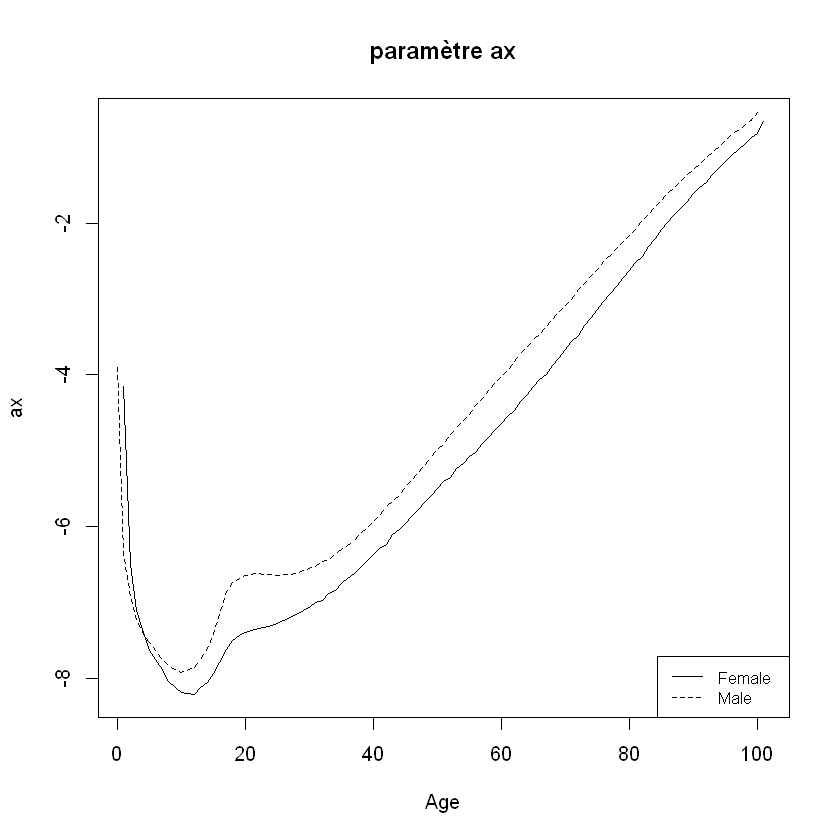

In [93]:
plot(angleterreLcaF$ax, main="paramètre ax", xlab="Age", ylab="ax", type="l")
lines(x=angleterreLcaM$age, y=angleterreLcaM$ax, main="ax", lty=2)
legend("bottomright", c("Female","Male"), cex=0.8,  lty=1:2)

Les paramètres ax représentent la tendance liée à l’effet isolé de l’âge sur les taux de mortalité. La courbe des ax suit la tendance des courbes des données empiriques. Les âges faibles ont une décroissance jusqu’à atteindre un minimum absolu atteint au niveau de l’âge de dix ans, une croissance puis une forte croissance jusqu’à la fin de la vie.

## Paramètre $b_x$

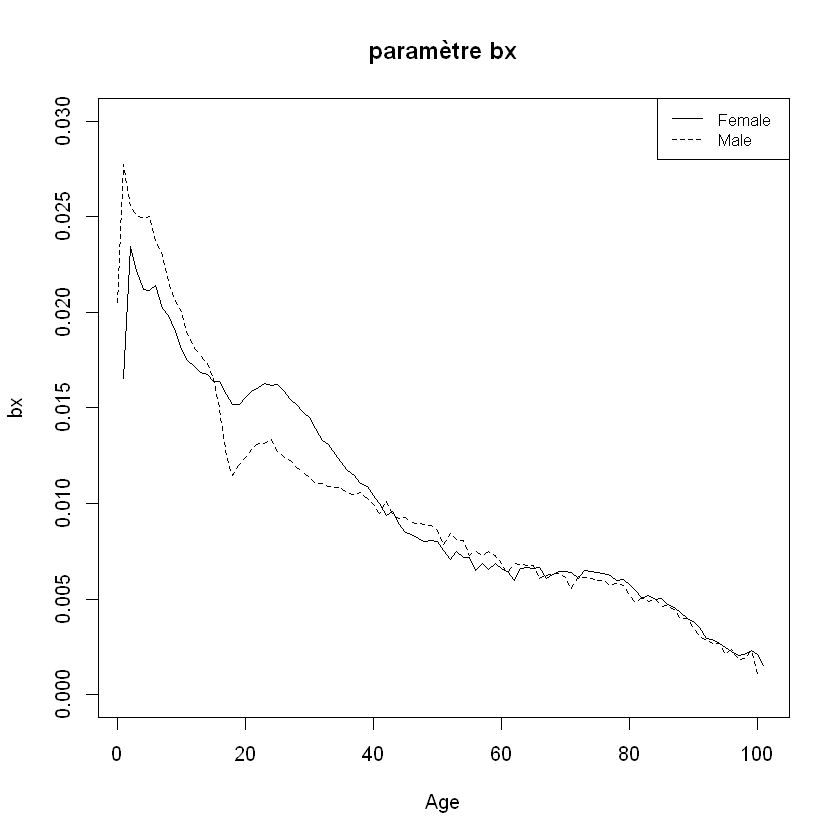

In [94]:
plot(angleterreLcaF$bx, main="paramètre bx", ylim=c(0,0.03),xlab="Age", ylab="bx", type="l")
lines(x=angleterreLcaM$age, y=angleterreLcaM$bx, main="ax", lty=2)
legend("topright",c("Female","Male"), cex=0.8,  lty=1:2)

Les paramètres $b_x$ représentent l’interaction de l’effet des années calendaires sur les taux de mortalité. Cet effet est toujours positif mais la valeur ne cesse de diminuer avec l’âge. Autrement dit, l’effet des années calendaires agit majoritairement avant 50 ans et de moins en moins au delà. On constate une bosse à 22 et une bosse plus légère à 68 ans. Pour des âges élevés, l’effet est quasi-inexistant puisque bx est presque nul. C'est explicable grâce au fait que l'amélioration des conditions de vie et de la médecine ont diminué largement la mortalité infantile. De plus, chez les hommes, l'année a un plus grand effet que chez les femmes.

## 4/

In [104]:
LC=StMoMo(link = "logit", staticAgeFun = TRUE, periodAgeFun = "NP")

In [106]:
LCfit=fit(lc(), data = angleterreMoMo)

Warning message in fit.StMoMo(lc(), data = angleterreMoMo):
"StMoMo: 228 data points have 
                  non-positive exposures and have been zero weighted
"Warning message in fit.StMoMo(lc(), data = angleterreMoMo):
"StMoMo: 228 missing values which have been zero weighted
"

StMoMo: The following cohorts have been zero weigthed: 1812 1813 1814 1815 
StMoMo: Start fitting with gnm
Initialising
Running start-up iterations..
Running main iterations...................
Done
StMoMo: Finish fitting with gnm


In [122]:
help(fitted)

In [130]:
LCfit

Stochastic Mortality Model fit
Call: fit.StMoMo(object = lc(), data = angleterreMoMo)

Poisson model with predictor: log m[x,t] = a[x] + b1[x] k1[t]

Data:  U.k
Series:  male
Years in fit: 1922 - 2016
Ages in fit: 0 - 110 

Log-likelihood:  -235671.84
Deviance:  382904.39
Number of parameters:  315

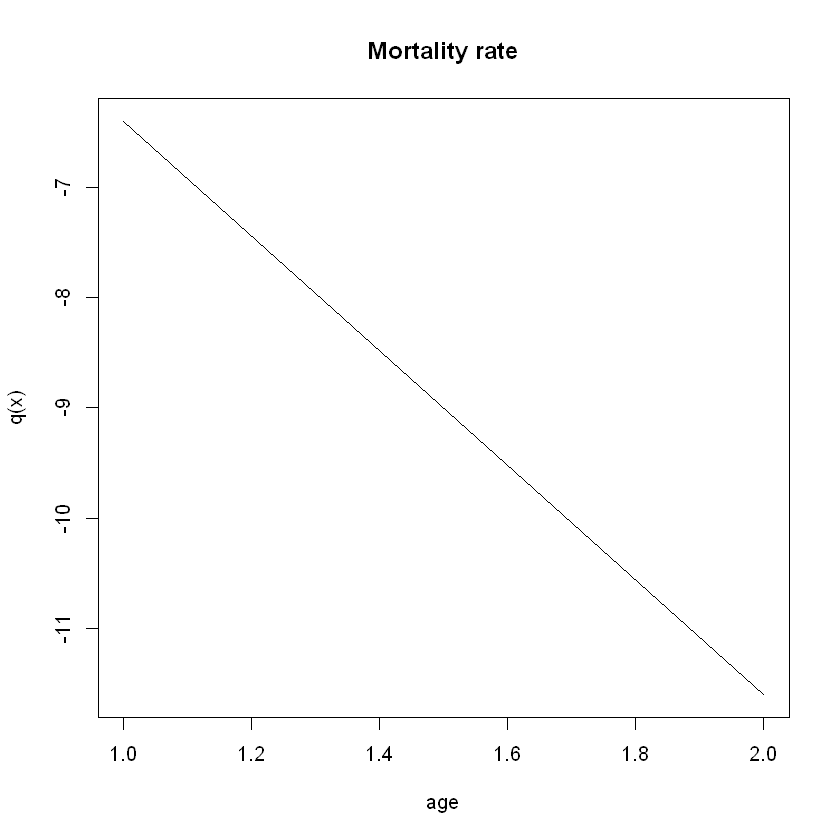

In [129]:
plot(extractCohort(fitted(LCfit),cohort=2015), xlab = "age", ylab = "q(x)",type="l",
main = "Mortality rate")

In [83]:
library("StMoMo")

Warning message:
"package 'StMoMo' was built under R version 3.6.3"Loading required package: gnm
Warning message:
"package 'gnm' was built under R version 3.6.3"

In [37]:
#angleterreMoMo <- StMoMoData(angleterre,series="male")
angleterreMoMo <- StMoMoData(angleterre,series="total")

In [1]:
LCfit <- fit(lc(), data = angleterreMoMo, ages.fit = 0:100)
#Plot forecast mortality rates for the 1950 cohort
#LCfor <- forecast(LCfit)
plot(extractCohort(fitted(LCfit, type = "rates")), 
xlab = "age", ylab = "Mortality rate", 
main = "Mortality rate",type='l',log="y")
#lines(extractCohort(LCfor$rates), lty = 2, col = "blue")

ERROR: Error in fit(lc(), data = angleterreMoMo, ages.fit = 0:100): could not find function "fit"


In [87]:
angleterreMoMoM<- StMoMoData(angleterre,series="male")
angleterreMoMoF <- StMoMoData(angleterre,series="female")
angleterreMoMoT <- StMoMoData(angleterre,series="total")


LCfitM <- fit(lc(), data = angleterreMoMoM)
LCfitF <- fit(lc(), data = angleterreMoMoF)
LCfitT <- fit(lc(), data = angleterreMoMoT)


plot(LCfitF$ax, main="paramètre ax", xlab="Age", ylab="ax", type="l")
lines(x=LCfitM$age, y=LCfitM$ax, main="ax", lty=2)
legend("bottomright", c("Female","Male"), cex=0.8,  lty=1:2)


plot(LCfitF$bx, main="paramètre bx", ylim=c(0,0.03),xlab="Age", ylab="bx", type="l")
lines(x=LCfitM$age, y=LCfitM$bx, main="ax", lty=2)
legend("topright",c("Female","Male"), cex=0.8,  lty=1:2)

In [88]:
LCfitM <- fit(lc(), data = angleterreMoMoM)
LCfitF <- fit(lc(), data = angleterreMoMoF)
LCfitT <- fit(lc(), data = angleterreMoMoT)

Warning message in fit.StMoMo(lc(), data = angleterreMoMoM):
"StMoMo: 228 data points have 
                  non-positive exposures and have been zero weighted
"Warning message in fit.StMoMo(lc(), data = angleterreMoMoM):
"StMoMo: 228 missing values which have been zero weighted
"

StMoMo: The following cohorts have been zero weigthed: 1812 1813 1814 1815 
StMoMo: Start fitting with gnm
Initialising
Running start-up iterations..
Running main iterations....................
Done
StMoMo: Finish fitting with gnm


Warning message in fit.StMoMo(lc(), data = angleterreMoMoF):
"StMoMo: 95 data points have 
                  non-positive exposures and have been zero weighted
"Warning message in fit.StMoMo(lc(), data = angleterreMoMoF):
"StMoMo: 95 missing values which have been zero weighted
"

StMoMo: The following cohorts have been zero weigthed: 1812 1813 1814 
StMoMo: Start fitting with gnm
Initialising
Running start-up iterations..
Running main iterations..........
Done
StMoMo: Finish fitting with gnm


Warning message in fit.StMoMo(lc(), data = angleterreMoMoT):
"StMoMo: 87 data points have 
                  non-positive exposures and have been zero weighted
"Warning message in fit.StMoMo(lc(), data = angleterreMoMoT):
"StMoMo: 87 missing values which have been zero weighted
"

StMoMo: The following cohorts have been zero weigthed: 1812 1813 1814 
StMoMo: Start fitting with gnm
Initialising
Running start-up iterations..
Running main iterations...........
Done
StMoMo: Finish fitting with gnm


## Paramètre $a_x$

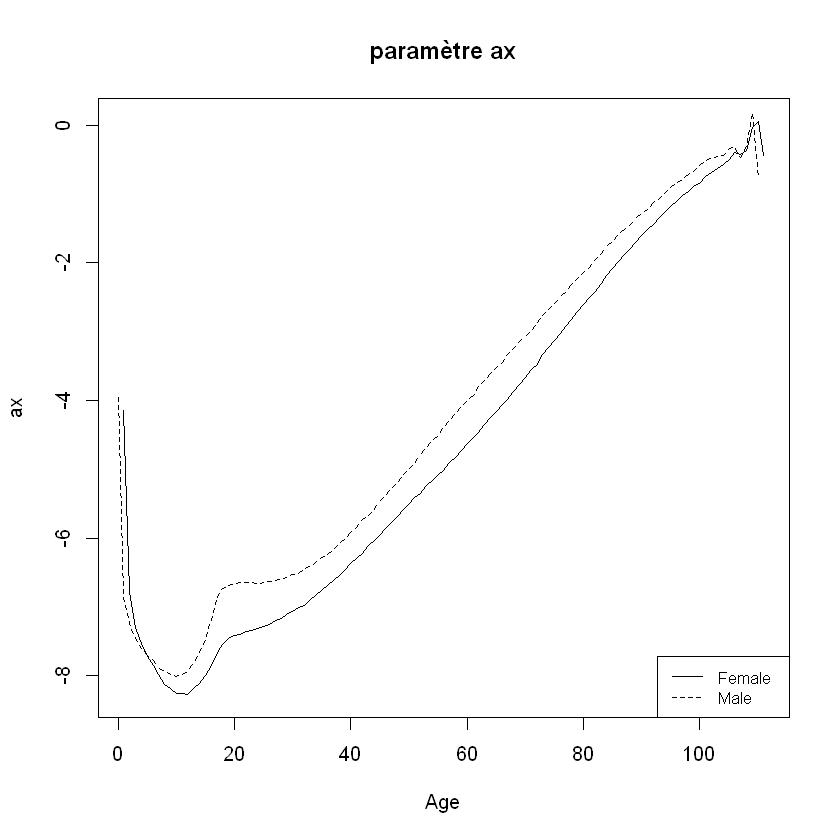

In [89]:
plot(LCfitF$ax, main="paramètre ax", xlab="Age", ylab="ax", type="l")
lines(x=LCfitM$age, y=LCfitM$ax, main="ax", lty=2)
legend("bottomright", c("Female","Male"), cex=0.8,  lty=1:2)

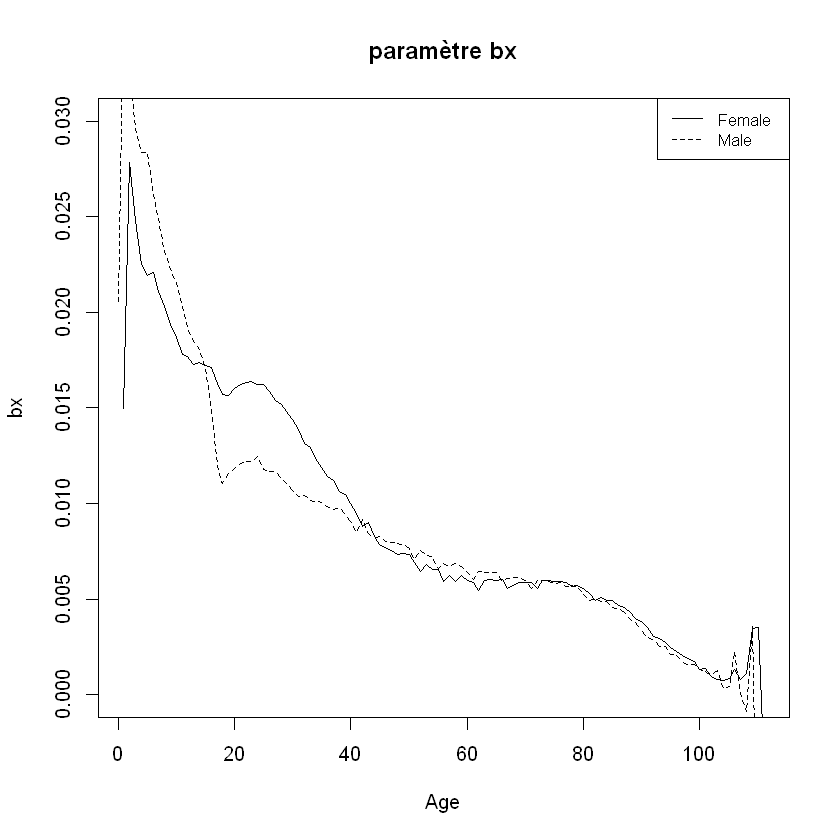

In [91]:
plot(LCfitF$bx, main="paramètre bx", ylim=c(0,0.03),xlab="Age", ylab="bx", type="l")
lines(x=LCfitM$age, y=LCfitM$bx, main="ax", lty=2)
legend("topright",c("Female","Male"), cex=0.8,  lty=1:2)

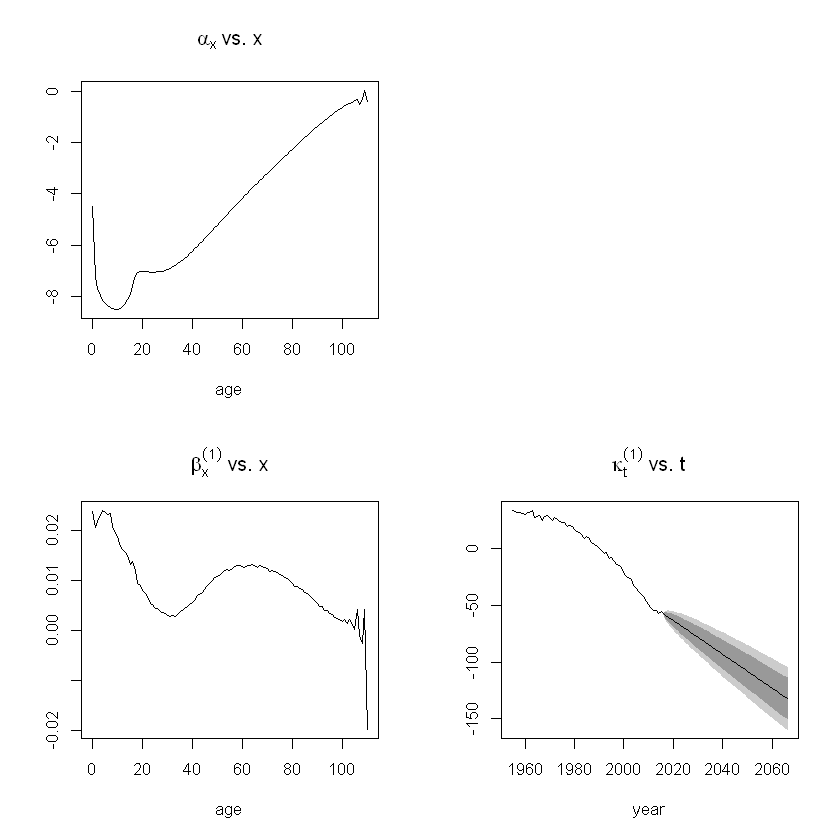

In [48]:
plot(LCfor)

In [49]:
LCfor

Stochastic Mortality Model forecast
Call: forecast.fitStMoMo(object = LCfit)

Poisson model with predictor: log m[x,t] = a[x] + b1[x] k1[t]

kt model: mrwd
Jump-off method: fit
Data:  United Kingdom
Series:  male
Years in forecast: 2017 - 2066
Ages in forecast: 0 - 110 

In [46]:
angleterreLcaT

Lee-Carter analysis

Call: lca(data = angleterre, series = "total", max.age = 100) 

Adjustment method: dt
Region: U.k
Years in fit: 1922 - 2016
Ages in fit: 0 - 100 

Percentage variation explained: 95.8%

In [131]:
help(forecast)

In [134]:
LCfor <- forecast(LCfit,h=25)

In [135]:
LCfor

Stochastic Mortality Model forecast
Call: forecast.fitStMoMo(object = LCfit, h = 25)

Poisson model with predictor: log m[x,t] = a[x] + b1[x] k1[t]

kt model: mrwd
Jump-off method: fit
Data:  U.k
Series:  male
Years in forecast: 2017 - 2041
Ages in forecast: 0 - 110 

In [137]:
LCfor$year[]

[1] 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031
[16] 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041

In [95]:
mu.an <- function(a){
    Da <- Deces[Deces$Year==a,]
    Ea <- Expo[Expo$Year==a,]
    MUa <- Da[,3:5]/Ea[,3:5]
       titre <- paste("Taux de mortalité en ",a,sep=" ")
    plot(Ages,log(MUa[,1]),type="l",xlab="Age", ylab="taux de mortalité",main=titre,lty=1,col="Red")
    lines(Ages,log(MUa[,2]),col="blue")
    legend(c("Femmes","Hommes"),col=c("Red","blue"),lty=1, cex=0.5)
          }
#(puisque lannee maximale de la base est  2016 on va tracer les 2 plots 2015 et 2016

par(mfrow = c(1, 2))
mu.an(2000)
mu.an(2015)

ERROR: Error in mu.an(2000): object 'Deces' not found


In [20]:
install.packages("lifecontingencies")

package 'lifecontingencies' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\amine\AppData\Local\Temp\Rtmps33fb6\downloaded_packages


In [28]:
library(lifecontingencies)

Warning message:
"package 'lifecontingencies' was built under R version 3.6.3"

ERROR: Error: package or namespace load failed for 'lifecontingencies' in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 namespace 'Rcpp' 1.0.1 is already loaded, but >= 1.0.2 is required


In [18]:
TD8890 <- new("lifetable", x=angleterre$x, lx= angleterre$lx)

ERROR: Error in getClass(Class, where = topenv(parent.frame())): "lifetable" is not a defined class


In [ ]:
TD8890tb <- new("actuarialtable", x=angleterre@x, lx=TD8890@lx, interest=2.5/100)

In [29]:
help(exn)